<a href="https://colab.research.google.com/github/hoonzi-s/APC/blob/main/%231ALK_213BTMRVP_R3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Start

## Import Libraries

In [2077]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2078]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2079]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split as tts
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score

## Get Data

In [2080]:
data_origin = pd.read_csv('/content/drive/MyDrive/#1 ALK RVP CSV.csv', index_col = 0)
data_origin.info()
data_origin.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 2722 entries, 2014-09-16 to 2022-05-31
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   RVP_LAB         2722 non-null   float64
 1   S.B5.213TI2804  2722 non-null   float64
 2   S.B5.213PI2806  2722 non-null   float64
 3   S.B5.213FC2602  2722 non-null   float64
dtypes: float64(4)
memory usage: 106.3+ KB


,RVP_LAB,S.B5.213TI2804,S.B5.213PI2806,S.B5.213FC2602
count,2722.000000,2722.000000,2722.000000,2722.000000
mean,39.328619,133.949733,335.077938,85.899122
std,3.421906,3.458029,29.807069,10.770141
min,28.500000,97.606803,291.821242,35.510519
25%,37.425000,131.972769,318.099483,80.955274
50%,39.000000,133.415073,325.602608,88.562405
75%,40.700000,136.136184,338.399182,92.767635
max,98.600000,145.939417,520.512731,113.968771


In [2081]:
data_origin.columns = ['RVP', 'T', 'P', 'F']
data = data_origin[(data_origin['RVP'] < 70) & (data_origin['T'] > 120)]
data

,RVP,T,P,F
2014-09-16,35.5,136.847447,334.665971,89.578694
2014-09-17,33.5,138.822292,338.164993,89.462762
2014-09-18,34.4,138.079717,339.017050,91.780995
2014-09-19,34.3,137.367731,335.839848,96.444227
2014-09-20,35.2,137.442057,349.710404,91.365322
...,...,...,...,...
2022-05-27,41.2,130.516820,336.686003,83.901707
2022-05-28,41.1,131.254566,326.181325,81.637548
2022-05-29,49.0,130.927377,377.945998,84.366741
2022-05-30,42.5,130.193366,331.879981,86.252752


In [2082]:
A = 7.00961   # Temperature in Celsius
B = 1022.48
C = 248.145
P_ref = (335 / 101.325 + 1) * 760   # kPa to mmHg

data['PCT'] = data.iloc[:, 1] + B * np.log10(P_ref / (data.iloc[:, 2] / 101.325 + 1) / 760) / (A - np.log10(P_ref)) / (A - np.log10((data.iloc[:, 2] / 101.325 + 1) * 760))
data

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,RVP,T,P,F,PCT
2014-09-16,35.5,136.847447,334.665971,89.578694,136.875290
2014-09-17,33.5,138.822292,338.164993,89.462762,138.559265
2014-09-18,34.4,138.079717,339.017050,91.780995,137.746123
2014-09-19,34.3,137.367731,335.839848,96.444227,137.297795
2014-09-20,35.2,137.442057,349.710404,91.365322,136.231441
...,...,...,...,...,...
2022-05-27,41.2,130.516820,336.686003,83.901707,130.376527
2022-05-28,41.1,131.254566,326.181325,81.637548,131.995087
2022-05-29,49.0,130.927377,377.945998,84.366741,127.473692
2022-05-30,42.5,130.193366,331.879981,86.252752,130.454063


## Set 'n' and 'information'

In [2083]:
n = 100
information = pd.DataFrame(columns=['Variables', 'Solution', 'Alpha', 'Scaler', 'train_R2', 'test_R2', 'MAE', 'MSE'])
information

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,MAE,MSE


# Poly T, P

## LinearRegression

In [2084]:
input = data[['T', 'P']]
target = data['RVP']

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []

vars = 'Poly T, P'
soln = 'LinearRegression'
alpha = np.nan
scaler = 'Standard'

In [2085]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = LinearRegression()
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))

new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,MAE,MSE
0,"Poly T, P",LinearRegression,NaN,Standard,0.540641,0.52769,1.604527,4.802393


## Ridge

### Ridge (alpha = 0.001)

In [2086]:
input = data[['T', 'P']]
target = data['RVP']

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []

vars = 'Poly T, P'
soln = 'Ridge'
alpha = 0.001
scaler = 'Standard'

In [2087]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Ridge(alpha = alpha)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))

new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,MAE,MSE
0,"Poly T, P",Ridge,0.001,Standard,0.54041,0.529128,1.604743,4.804215


### Ridge (alpha = 0.01)

In [2088]:
input = data[['T', 'P']]
target = data['RVP']

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []

vars = 'Poly T, P'
soln = 'Ridge'
alpha = 0.01
scaler = 'Standard'

In [2089]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Ridge(alpha = alpha)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))

new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,MAE,MSE
0,"Poly T, P",Ridge,0.01,Standard,0.541122,0.526115,1.604611,4.803511


### Ridge (alpha = 0.1)

In [2090]:
input = data[['T', 'P']]
target = data['RVP']

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []

vars = 'Poly T, P'
soln = 'Ridge'
alpha = 0.1
scaler = 'Standard'

In [2091]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Ridge(alpha = alpha)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))

new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,MAE,MSE
0,"Poly T, P",Ridge,0.1,Standard,0.537496,0.535503,1.604475,4.808029


### Ridge (alpha = 1)

In [2092]:
input = data[['T', 'P']]
target = data['RVP']

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []

vars = 'Poly T, P'
soln = 'Ridge'
alpha = 1
scaler = 'Standard'

In [2093]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Ridge(alpha = alpha)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))

new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,MAE,MSE
0,"Poly T, P",Ridge,1,Standard,0.535643,0.528692,1.608087,4.840424


### Ridge (alpha = 10)

In [2094]:
input = data[['T', 'P']]
target = data['RVP']

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []

vars = 'Poly T, P'
soln = 'Ridge'
alpha = 10
scaler = 'Standard'

In [2095]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Ridge(alpha = alpha)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))

new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,MAE,MSE
0,"Poly T, P",Ridge,10,Standard,0.528363,0.5262,1.617805,4.904791


### Ridge (alpha = 100)

In [2096]:
input = data[['T', 'P']]
target = data['RVP']

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []

vars = 'Poly T, P'
soln = 'Ridge'
alpha = 100
scaler = 'Standard'

In [2097]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Ridge(alpha = alpha)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))

new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,MAE,MSE
0,"Poly T, P",Ridge,100,Standard,0.523026,0.517215,1.625216,4.968408


## Lasso

### Lasso (alpha = 0.001)

In [2098]:
input = data[['T', 'P']]
target = data['RVP']

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []

vars = 'Poly T, P'
soln = 'Lasso'
alpha = 0.001
scaler = 'Standard'

In [2099]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Lasso(alpha = alpha, max_iter = 30000)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))

new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,MAE,MSE
0,"Poly T, P",Lasso,0.001,Standard,0.535136,0.534256,1.606671,4.829862


### Lasso (alpha = 0.01)

In [2100]:
input = data[['T', 'P']]
target = data['RVP']

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []

vars = 'Poly T, P'
soln = 'Lasso'
alpha = 0.01
scaler = 'Standard'

In [2101]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Lasso(alpha = alpha, max_iter = 2000)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))

new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.823e+01, tolerance: 2.040e+00
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


,Variables,Solution,Alpha,Scaler,train_R2,test_R2,MAE,MSE
0,"Poly T, P",Lasso,0.01,Standard,0.528402,0.523918,1.618863,4.908861


### Lasso (alpha = 0.1)

In [2102]:
input = data[['T', 'P']]
target = data['RVP']

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []

vars = 'Poly T, P'
soln = 'Lasso'
alpha = 0.1
scaler = 'Standard'

In [2103]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Lasso(alpha = alpha)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))

new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,MAE,MSE
0,"Poly T, P",Lasso,0.1,Standard,0.524942,0.516779,1.621596,4.954765


# Poly PCT, P

## LinearRegression

In [2104]:
input = data[['PCT', 'P']]
target = data['RVP']

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []

vars = 'Poly PCT, P'
soln = 'LinearRegression'
alpha = np.nan
scaler = 'Standard'

In [2105]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = LinearRegression()
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))

new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,MAE,MSE
0,"Poly PCT, P",LinearRegression,NaN,Standard,0.539793,0.531148,1.604241,4.802626


## Ridge

### Ridge (alpha = 0.001)

In [2106]:
input = data[['PCT', 'P']]
target = data['RVP']

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []

vars = 'Poly PCT, P'
soln = 'Ridge'
alpha = 0.001
scaler = 'Standard'

In [2107]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Ridge(alpha = alpha)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))

new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,MAE,MSE
0,"Poly PCT, P",Ridge,0.001,Standard,0.5398,0.529754,1.604573,4.803439


### Ridge (alpha = 0.01)

In [2108]:
input = data[['PCT', 'P']]
target = data['RVP']

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []

vars = 'Poly PCT, P'
soln = 'Ridge'
alpha = 0.01
scaler = 'Standard'

In [2109]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Ridge(alpha = alpha)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))

new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,MAE,MSE
0,"Poly PCT, P",Ridge,0.01,Standard,0.539623,0.531229,1.604467,4.803001


### Ridge (alpha = 0.1)

In [2110]:
input = data[['PCT', 'P']]
target = data['RVP']

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []

vars = 'Poly PCT, P'
soln = 'Ridge'
alpha = 0.1
scaler = 'Standard'

In [2111]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Ridge(alpha = alpha)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))

new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,MAE,MSE
0,"Poly PCT, P",Ridge,0.1,Standard,0.538392,0.534819,1.60338,4.802734


### Ridge (alpha = 1)

In [2112]:
input = data[['PCT', 'P']]
target = data['RVP']

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []

vars = 'Poly PCT, P'
soln = 'Ridge'
alpha = 1
scaler = 'Standard'

In [2113]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Ridge(alpha = alpha)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))

new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,MAE,MSE
0,"Poly PCT, P",Ridge,1,Standard,0.53591,0.531831,1.606385,4.828042


### Ridge (alpha = 10)

In [2114]:
input = data[['PCT', 'P']]
target = data['RVP']

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []

vars = 'Poly PCT, P'
soln = 'Ridge'
alpha = 10
scaler = 'Standard'

In [2115]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Ridge(alpha = alpha)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))

new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,MAE,MSE
0,"Poly PCT, P",Ridge,10,Standard,0.531275,0.530915,1.612375,4.868149


### Ridge (alpha = 100)

In [2116]:
input = data[['PCT', 'P']]
target = data['RVP']

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []

vars = 'Poly PCT, P'
soln = 'Ridge'
alpha = 100
scaler = 'Standard'

In [2117]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Ridge(alpha = alpha)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))

new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,MAE,MSE
0,"Poly PCT, P",Ridge,100,Standard,0.529527,0.524678,1.615985,4.899125


## Lasso

### Lasso (alpha = 0.001)

In [2118]:
input = data[['PCT', 'P']]
target = data['RVP']

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []

vars = 'Poly PCT, P'
soln = 'Lasso'
alpha = 0.001
scaler = 'Standard'

In [2119]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Lasso(alpha = alpha, max_iter = 30000)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))

new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,MAE,MSE
0,"Poly PCT, P",Lasso,0.001,Standard,0.536519,0.537238,1.604704,4.812598


### Lasso (alpha = 0.01)

In [2120]:
input = data[['PCT', 'P']]
target = data['RVP']

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []

vars = 'Poly PCT, P'
soln = 'Lasso'
alpha = 0.01
scaler = 'Standard'

In [2121]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Lasso(alpha = alpha, max_iter = 2000)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))

new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,MAE,MSE
0,"Poly PCT, P",Lasso,0.01,Standard,0.531233,0.525573,1.614576,4.881637


### Lasso (alpha = 0.1)

In [2122]:
input = data[['PCT', 'P']]
target = data['RVP']

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []

vars = 'Poly PCT, P'
soln = 'Lasso'
alpha = 0.1
scaler = 'Standard'

In [2123]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Lasso(alpha = alpha)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))

new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,MAE,MSE
0,"Poly PCT, P",Lasso,0.1,Standard,0.528517,0.527925,1.61437,4.898398


# Poly PCT, P, F

## LinearRegression

In [2124]:
input = data[['PCT', 'P', 'F']]

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []

vars = 'Poly PCT, P, F'
soln = 'LinearRegression'
alpha = np.nan
scaler = 'Standard'

In [2125]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = LinearRegression()
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))

new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,MAE,MSE
0,"Poly PCT, P, F",LinearRegression,NaN,Standard,0.559939,0.546126,1.568454,4.606755


## Ridge

### Ridge (alpha = 0.001)

In [2126]:
input = data[['PCT', 'P', 'F']]

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []

vars = 'Poly PCT, P, F'
soln = 'Ridge'
alpha = 0.001
scaler = 'Standard'

In [2127]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Ridge(alpha = alpha)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))

new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,MAE,MSE
0,"Poly PCT, P, F",Ridge,0.001,Standard,0.56021,0.546025,1.56813,4.605565


### Ridge (alpha = 0.01)

In [2128]:
input = data[['PCT', 'P', 'F']]

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []

vars = 'Poly PCT, P, F'
soln = 'Ridge'
alpha = 0.01
scaler = 'Standard'

In [2129]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Ridge(alpha = alpha)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))

new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,MAE,MSE
0,"Poly PCT, P, F",Ridge,0.01,Standard,0.559069,0.54959,1.568061,4.605374


### Ridge (alpha = 0.1)

In [2130]:
input = data[['PCT', 'P', 'F']]

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []

vars = 'Poly PCT, P, F'
soln = 'Ridge'
alpha = 0.1
scaler = 'Standard'

In [2131]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Ridge(alpha = alpha)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))

new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,MAE,MSE
0,"Poly PCT, P, F",Ridge,0.1,Standard,0.558148,0.547365,1.568566,4.616682


### Ridge (alpha = 1)

In [2132]:
input = data[['PCT', 'P', 'F']]

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []

vars = 'Poly PCT, P, F'
soln = 'Ridge'
alpha = 1
scaler = 'Standard'

In [2133]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Ridge(alpha = alpha)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))

new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,MAE,MSE
0,"Poly PCT, P, F",Ridge,1,Standard,0.550718,0.544669,1.573466,4.681744


### Ridge (alpha = 10)

In [2134]:
input = data[['PCT', 'P', 'F']]

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []

vars = 'Poly PCT, P, F'
soln = 'Ridge'
alpha = 10
scaler = 'Standard'

In [2135]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Ridge(alpha = alpha)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))

new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,MAE,MSE
0,"Poly PCT, P, F",Ridge,10,Standard,0.543533,0.536327,1.582313,4.7592


### Ridge (alpha = 100)

In [2136]:
input = data[['PCT', 'P', 'F']]

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []

vars = 'Poly PCT, P, F'
soln = 'Ridge'
alpha = 100
scaler = 'Standard'

In [2137]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Ridge(alpha = alpha)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))

new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,MAE,MSE
0,"Poly PCT, P, F",Ridge,100,Standard,0.538994,0.530776,1.588775,4.809204


## Lasso

### Lasso (alpha = 0.001)

In [2138]:
input = data[['PCT', 'P', 'F']]

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []

vars = 'Poly PCT, P, F'
soln = 'Lasso'
alpha = 0.001
scaler = 'Standard'

In [2139]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Lasso(alpha = alpha, max_iter = 30000)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))

new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,MAE,MSE
0,"Poly PCT, P, F",Lasso,0.001,Standard,0.554218,0.55773,1.568666,4.620804


### Lasso (alpha = 0.01)

In [2140]:
input = data[['PCT', 'P', 'F']]

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []

vars = 'Poly PCT, P, F'
soln = 'Lasso'
alpha = 0.01
scaler = 'Standard'

In [2141]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Lasso(alpha = alpha, max_iter = 2000)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))

new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,MAE,MSE
0,"Poly PCT, P, F",Lasso,0.01,Standard,0.538346,0.537327,1.587189,4.797075


### Lasso (alpha = 0.1)

In [2142]:
input = data[['PCT', 'P', 'F']]

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []

vars = 'Poly PCT, P, F'
soln = 'Lasso'
alpha = 0.1
scaler = 'Standard'

In [2143]:
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Lasso(alpha = alpha)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))

new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,MAE,MSE
0,"Poly PCT, P, F",Lasso,0.1,Standard,0.520027,0.57375,1.601057,4.852458


# Poly T, P, F

## LinearRegression

In [2144]:
input = data[['T', 'P', 'F']]

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []

vars = 'Poly T, P, F'
soln = 'LinearRegression'
alpha = np.nan
scaler = 'Standard'

In [2145]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = LinearRegression()
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))

new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,MAE,MSE
0,"Poly T, P, F",LinearRegression,NaN,Standard,0.558079,0.551963,1.568285,4.605421


## Ridge

### Ridge (alpha = 0.001)

In [2146]:
input = data[['T', 'P', 'F']]

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []

vars = 'Poly T, P, F'
soln = 'Ridge'
alpha = 0.001
scaler = 'Standard'

In [2147]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Ridge(alpha = alpha)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))

new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,MAE,MSE
0,"Poly T, P, F",Ridge,0.001,Standard,0.557694,0.552885,1.568461,4.605096


### Ridge (alpha = 0.01)

In [2148]:
input = data[['T', 'P', 'F']]

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []

vars = 'Poly T, P, F'
soln = 'Ridge'
alpha = 0.01
scaler = 'Standard'

In [2149]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Ridge(alpha = alpha)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))

new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,MAE,MSE
0,"Poly T, P, F",Ridge,0.01,Standard,0.560446,0.545344,1.5684,4.606316


### Ridge (alpha = 0.1)

In [2150]:
input = data[['T', 'P', 'F']]

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []

vars = 'Poly T, P, F'
soln = 'Ridge'
alpha = 0.1
scaler = 'Standard'

In [2151]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Ridge(alpha = alpha)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))

new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,MAE,MSE
0,"Poly T, P, F",Ridge,0.1,Standard,0.558958,0.546513,1.568688,4.614011


### Ridge (alpha = 1)

In [2152]:
input = data[['T', 'P', 'F']]

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []

vars = 'Poly T, P, F'
soln = 'Ridge'
alpha = 1
scaler = 'Standard'

In [2153]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Ridge(alpha = alpha)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))

new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,MAE,MSE
0,"Poly T, P, F",Ridge,1,Standard,0.551919,0.541487,1.573488,4.679879


### Ridge (alpha = 10)

In [2154]:
input = data[['T', 'P', 'F']]

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []

vars = 'Poly T, P, F'
soln = 'Ridge'
alpha = 10
scaler = 'Standard'

In [2155]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Ridge(alpha = alpha)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))

new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,MAE,MSE
0,"Poly T, P, F",Ridge,10,Standard,0.539692,0.534921,1.587222,4.792387


### Ridge (alpha = 100)

In [2156]:
input = data[['T', 'P', 'F']]

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []

vars = 'Poly T, P, F'
soln = 'Ridge'
alpha = 100
scaler = 'Standard'

In [2157]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Ridge(alpha = alpha)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))

new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,MAE,MSE
0,"Poly T, P, F",Ridge,100,Standard,0.53065,0.527114,1.600689,4.88456


## Lasso

### Lasso (alpha = 0.001)

In [2158]:
input = data[['T', 'P', 'F']]

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []

vars = 'Poly T, P, F'
soln = 'Lasso'
alpha = 0.001
scaler = 'Standard'

In [2159]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Lasso(alpha = alpha, max_iter = 30000)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))

new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,MAE,MSE
0,"Poly T, P, F",Lasso,0.001,Standard,0.558949,0.541619,1.569715,4.62631


### Lasso (alpha = 0.01)

In [2160]:
input = data[['T', 'P', 'F']]

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []

vars = 'Poly T, P, F'
soln = 'Lasso'
alpha = 0.01
scaler = 'Standard'

In [2161]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Lasso(alpha = alpha, max_iter = 30000)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))

new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.498e+01, tolerance: 2.072e+00
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.077e+01, tolerance: 2.163e+00
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisa

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,MAE,MSE
0,"Poly T, P, F",Lasso,0.01,Standard,0.536101,0.53206,1.592022,4.827676


### Lasso (alpha = 0.1)

In [2162]:
input = data[['T', 'P', 'F']]

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []

vars = 'Poly T, P, F'
soln = 'Lasso'
alpha = 0.1
scaler = 'Standard'

In [2163]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Lasso(alpha = alpha)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))

new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,MAE,MSE
0,"Poly T, P, F",Lasso,0.1,Standard,0.528369,0.520419,1.611304,4.920112


# Poly T, P, F, PCT

## LinearRegression

In [2164]:
input = data[['T', 'P', 'F', 'PCT']]

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []

vars = 'Poly T, P, F, PCT'
soln = 'LinearRegression'
alpha = np.nan
scaler = 'Standard'

In [2165]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = LinearRegression()
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))

new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,MAE,MSE
0,"Poly T, P, F, PCT",LinearRegression,NaN,Standard,0.558992,0.550049,1.567768,4.604742


## Ridge

### Ridge (alpha = 0.001)

In [2166]:
input = data[['T', 'P', 'F', 'PCT']]

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []

vars = 'Poly T, P, F, PCT'
soln = 'Ridge'
alpha = 0.001
scaler = 'Standard'

In [2167]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Ridge(alpha = alpha)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))

new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,MAE,MSE
0,"Poly T, P, F, PCT",Ridge,0.001,Standard,0.560464,0.545786,1.568144,4.60545


### Ridge (alpha = 0.01)

In [2168]:
input = data[['T', 'P', 'F', 'PCT']]

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []

vars = 'Poly T, P, F, PCT'
soln = 'Ridge'
alpha = 0.01
scaler = 'Standard'

In [2169]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Ridge(alpha = alpha)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))

new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,MAE,MSE
0,"Poly T, P, F, PCT",Ridge,0.01,Standard,0.558198,0.551989,1.567748,4.604968


### Ridge (alpha = 0.1)

In [2170]:
input = data[['T', 'P', 'F', 'PCT']]

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []

vars = 'Poly T, P, F, PCT'
soln = 'Ridge'
alpha = 0.1
scaler = 'Standard'

In [2171]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Ridge(alpha = alpha)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))

new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,MAE,MSE
0,"Poly T, P, F, PCT",Ridge,0.1,Standard,0.558978,0.546018,1.568582,4.613648


### Ridge (alpha = 1)

In [2172]:
input = data[['T', 'P', 'F', 'PCT']]

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []

vars = 'Poly T, P, F, PCT'
soln = 'Ridge'
alpha = 1
scaler = 'Standard'

In [2173]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Ridge(alpha = alpha)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))

new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,MAE,MSE
0,"Poly T, P, F, PCT",Ridge,1,Standard,0.553289,0.542358,1.572956,4.668921


### Ridge (alpha = 10)

In [2174]:
input = data[['T', 'P', 'F', 'PCT']]

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []

vars = 'Poly T, P, F, PCT'
soln = 'Ridge'
alpha = 10
scaler = 'Standard'

In [2175]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Ridge(alpha = alpha)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))

new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,MAE,MSE
0,"Poly T, P, F, PCT",Ridge,10,Standard,0.544088,0.538785,1.581299,4.749655


### Ridge (alpha = 100)

In [2176]:
input = data[['T', 'P', 'F', 'PCT']]

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []

vars = 'Poly T, P, F, PCT'
soln = 'Ridge'
alpha = 100
scaler = 'Standard'

In [2177]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Ridge(alpha = alpha)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))

new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,MAE,MSE
0,"Poly T, P, F, PCT",Ridge,100,Standard,0.539003,0.528943,1.589047,4.814512


## Lasso

### Lasso (alpha = 0.001)

In [2178]:
input = data[['T', 'P', 'F', 'PCT']]

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []

vars = 'Poly T, P, F, PCT'
soln = 'Lasso'
alpha = 0.001
scaler = 'Standard'

In [2179]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Lasso(alpha = alpha, max_iter = 200000)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))

new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,MAE,MSE
0,"Poly T, P, F, PCT",Lasso,0.001,Standard,0.555394,0.55372,1.569349,4.62217


### Lasso (alpha = 0.01)

In [2180]:
input = data[['T', 'P', 'F', 'PCT']]

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []

vars = 'Poly T, P, F, PCT'
soln = 'Lasso'
alpha = 0.01
scaler = 'Standard'

In [2181]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Lasso(alpha = alpha, max_iter = 2000)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))

new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,MAE,MSE
0,"Poly T, P, F, PCT",Lasso,0.01,Standard,0.540039,0.532112,1.587048,4.797109


### Lasso (alpha = 0.1)

In [2182]:
input = data[['T', 'P', 'F', 'PCT']]

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []

vars = 'Poly T, P, F, PCT'
soln = 'Lasso'
alpha = 0.1
scaler = 'Standard'

In [2183]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Lasso(alpha = alpha)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))

new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,MAE,MSE
0,"Poly T, P, F, PCT",Lasso,0.1,Standard,0.538055,0.523006,1.595889,4.836483


# Result

In [2184]:
information

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,MAE,MSE
0,"Poly T, P",LinearRegression,NaN,Standard,0.540641,0.527690,1.604527,4.802393
0,"Poly T, P",Ridge,0.001,Standard,0.540410,0.529128,1.604743,4.804215
0,"Poly T, P",Ridge,0.010,Standard,0.541122,0.526115,1.604611,4.803511
0,"Poly T, P",Ridge,0.100,Standard,0.537496,0.535503,1.604475,4.808029
0,"Poly T, P",Ridge,1.000,Standard,0.535643,0.528692,1.608087,4.840424
0,"Poly T, P",Ridge,10.000,Standard,0.528363,0.526200,1.617805,4.904791
0,"Poly T, P",Ridge,100.000,Standard,0.523026,0.517215,1.625216,4.968408
0,"Poly T, P",Lasso,0.001,Standard,0.535136,0.534256,1.606671,4.829862
0,"Poly T, P",Lasso,0.010,Standard,0.528402,0.523918,1.618863,4.908861
0,"Poly T, P",Lasso,0.100,Standard,0.524942,0.516779,1.621596,4.954765


In [2201]:
pf = PolynomialFeatures(degree = 3)
pf.fit(input)
input_poly = pf.transform(input)

train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
sc = StandardScaler()
sc.fit(train_input)
input_poly = sc.transform(input_poly)
train_poly = sc.transform(train_input)
test_poly = sc.transform(test_input)

model = Lasso(alpha = 0.001, max_iter = 1000000)
model.fit(train_poly, train_target)

print(model.score(train_poly, train_target))
print(model.score(test_poly, test_target))
inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
print(MAE(target, inferential))
print(MSE(target, inferential))

print(model.coef_)
print(np.sum(model.coef_ == 0))
print(pf.get_feature_names_out())

0.5470108216552483
0.5882430443612676
1.5653633228889918
4.598841253015175
[ 0.          0.          0.          7.19495866  0.          0.
  0.          0.          0.          0.          1.49627686  0.25166418
  0.          0.         -0.          0.          0.         -0.
 -0.          0.          0.          0.         -0.         -0.
 -0.         -1.44016374  0.          0.          0.          0.
  1.37060592  1.86085101 -4.76305177 -4.83919252 -0.5321256 ]
26
['1' 'T' 'P' 'F' 'PCT' 'T^2' 'T P' 'T F' 'T PCT' 'P^2' 'P F' 'P PCT' 'F^2'
 'F PCT' 'PCT^2' 'T^3' 'T^2 P' 'T^2 F' 'T^2 PCT' 'T P^2' 'T P F' 'T P PCT'
 'T F^2' 'T F PCT' 'T PCT^2' 'P^3' 'P^2 F' 'P^2 PCT' 'P F^2' 'P F PCT'
 'P PCT^2' 'F^3' 'F^2 PCT' 'F PCT^2' 'PCT^3']


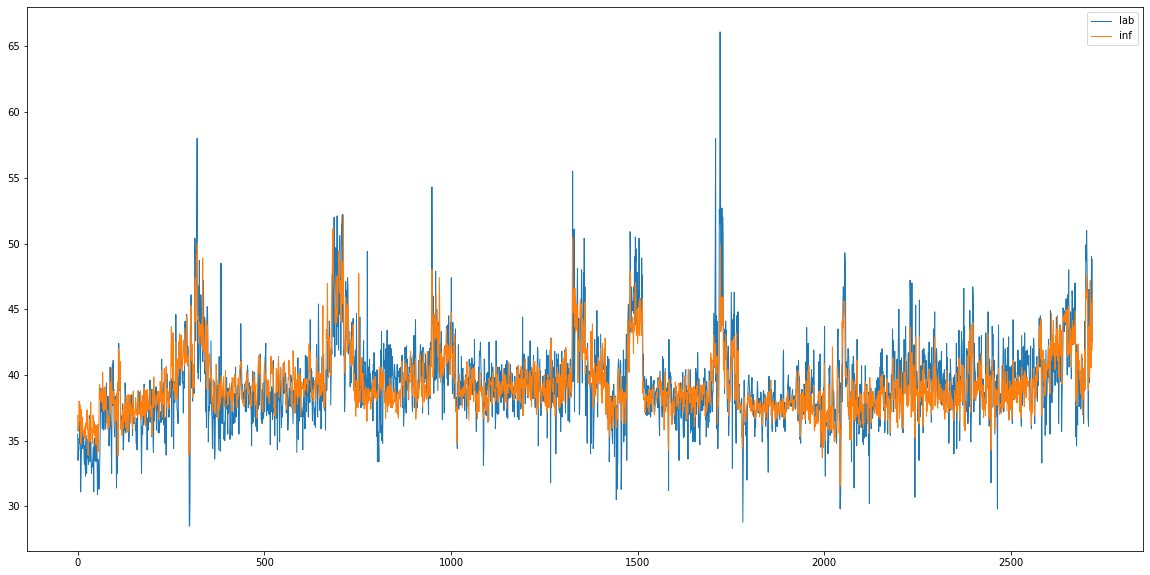

In [2202]:
length = len(target)
plt.figure(figsize = (20, 10))
plt.plot(np.arange(length), target, lw = 1, label = 'lab')
plt.plot(np.arange(length), inferential, lw = 1, label = 'inf')
plt.legend()
plt.show()

In [2203]:
information

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,MAE,MSE
0,"Poly T, P",LinearRegression,NaN,Standard,0.540641,0.527690,1.604527,4.802393
0,"Poly T, P",Ridge,0.001,Standard,0.540410,0.529128,1.604743,4.804215
0,"Poly T, P",Ridge,0.010,Standard,0.541122,0.526115,1.604611,4.803511
0,"Poly T, P",Ridge,0.100,Standard,0.537496,0.535503,1.604475,4.808029
0,"Poly T, P",Ridge,1.000,Standard,0.535643,0.528692,1.608087,4.840424
0,"Poly T, P",Ridge,10.000,Standard,0.528363,0.526200,1.617805,4.904791
0,"Poly T, P",Ridge,100.000,Standard,0.523026,0.517215,1.625216,4.968408
0,"Poly T, P",Lasso,0.001,Standard,0.535136,0.534256,1.606671,4.829862
0,"Poly T, P",Lasso,0.010,Standard,0.528402,0.523918,1.618863,4.908861
0,"Poly T, P",Lasso,0.100,Standard,0.524942,0.516779,1.621596,4.954765


In [2206]:
grouped = information['MAE'].groupby(information['Solution'])
grouped

In [2207]:
grouped.mean()

Solution
Lasso               1.597535
LinearRegression    1.582655
Ridge               1.589205
Name: MAE, dtype: float64

In [2217]:
mins = information[['MAE', 'MSE']].groupby([information['Variables'], information['Solution']]).min()
mins

MAE       MSE
Variables         Solution                            
Poly PCT, P       Lasso             1.604704  4.812598
                  LinearRegression  1.604241  4.802626
                  Ridge             1.603380  4.802734
Poly PCT, P, F    Lasso             1.568666  4.620804
                  LinearRegression  1.568454  4.606755
                  Ridge             1.568061  4.605374
Poly T, P         Lasso             1.606671  4.829862
                  LinearRegression  1.604527  4.802393
                  Ridge             1.604475  4.803511
Poly T, P, F      Lasso             1.569715  4.626310
                  LinearRegression  1.568285  4.605421
                  Ridge             1.568400  4.605096
Poly T, P, F, PCT Lasso             1.569349  4.622170
                  LinearRegression  1.567768  4.604742
                  Ridge             1.567748  4.604968